In [1]:
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
from mplsoccer.pitch import Pitch, VerticalPitch
import seaborn as sns
import json

import matplotlib.ticker as ticker
import matplotlib.patheffects as path_effects
import matplotlib.font_manager as fm
import matplotlib.colors as mcolors
from matplotlib import cm
from highlight_text import fig_text, ax_text
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib import cm
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch
from matplotlib.lines import Line2D


# We'll only use a vertical pitch for this tutorial
from PIL import Image
import urllib
import json
import os


In [2]:
FILE = './data/chesalz.json'

PLAYER_NAME ='Mateo Kovacic'

TOUCH_ID = 91
ASSIST_ID = [92,47,48,49,50,51,52]
KEY_PASS = [39,40,41,42,43,44,45,46]

In [3]:
with open(FILE) as f:
    d = json.load(f)

In [4]:
player_dict = dict(d['matchCentreData']['playerIdNameDictionary'])

player_data = [(x, player_dict[x]) for x in player_dict]
player_data = pd.DataFrame(player_data, columns=['playerId', 'player_name'])
player_data['playerId'] = player_data['playerId'].astype('int64')
# player_data.head()

In [5]:
passing_data = [x for x in d['matchCentreData']['events']]

passing_data = pd.json_normalize(passing_data)

passing_data = passing_data.drop([ 'type.value','period.value','outcomeType.value', 'id'], axis =1)
passing_data = pd.merge(passing_data, player_data, on=['playerId'])

In [6]:

# PLAYER_ID = passing_data[SequenceMatcher(None,passing_data['player_name'] , PLAYER_NAME).ratio()>0.5]['playerId'].iloc[1]
PLAYER_ID = passing_data[passing_data.player_name == PLAYER_NAME]['playerId'].iloc[1]
player_passes = passing_data.loc[passing_data.player_name == PLAYER_NAME, ['x', 'y', 'period.displayName']]
player_passes

,x,y,period.displayName
1232,63.0,93.4,FirstHalf
1233,20.2,65.8,FirstHalf
1234,25.4,90.9,FirstHalf
1235,62.9,56.6,FirstHalf
1236,66.6,47.4,FirstHalf
...,...,...,...
1292,69.0,88.1,SecondHalf
1293,33.5,75.1,SecondHalf
1294,34.3,75.6,SecondHalf
1295,34.7,80.7,SecondHalf


In [7]:
def find_teams(data):
    home_team = data['matchCentreData']['home']['name']
    away_team = data['matchCentreData']['away']['name']

    home_team_players = [x['playerId'] for x in data['matchCentreData']['home']['players']]
    away_team_players = [x['playerId'] for x in data['matchCentreData']['away']['players']]

    if(PLAYER_ID in home_team_players):
        team = home_team
        oppositon = away_team
    else:
        team = away_team
        oppositon = home_team
    return team, oppositon

In [8]:
playing_team, opp = find_teams(d)

In [9]:
colors = [
    '#D2E5FB',
    '#C8DAEE',
    '#B9CEE4',
    '#AAC4E0',
    '#9EBAD9',
    '#96B4D5',
    '#86A7CB',
    '#7B9EC4',
    '#7398C1',
    '#668CB5',
    '#557FAC',
    '#4975A5',
    '#4270A1',
    '#366496',
    '#285689',
    '#215083',
    '#1C4A7D',
    '#134173',
    '#0C3B6D',
    '#053161',
]
soc_cm = LinearSegmentedColormap.from_list('SOC', colors, N=50)
cm.register_cmap(name='SOC', cmap=soc_cm)

findfont: Font family ['DM Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['DM Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['DM Sans'] not found. Falling back to DejaVu Sans.


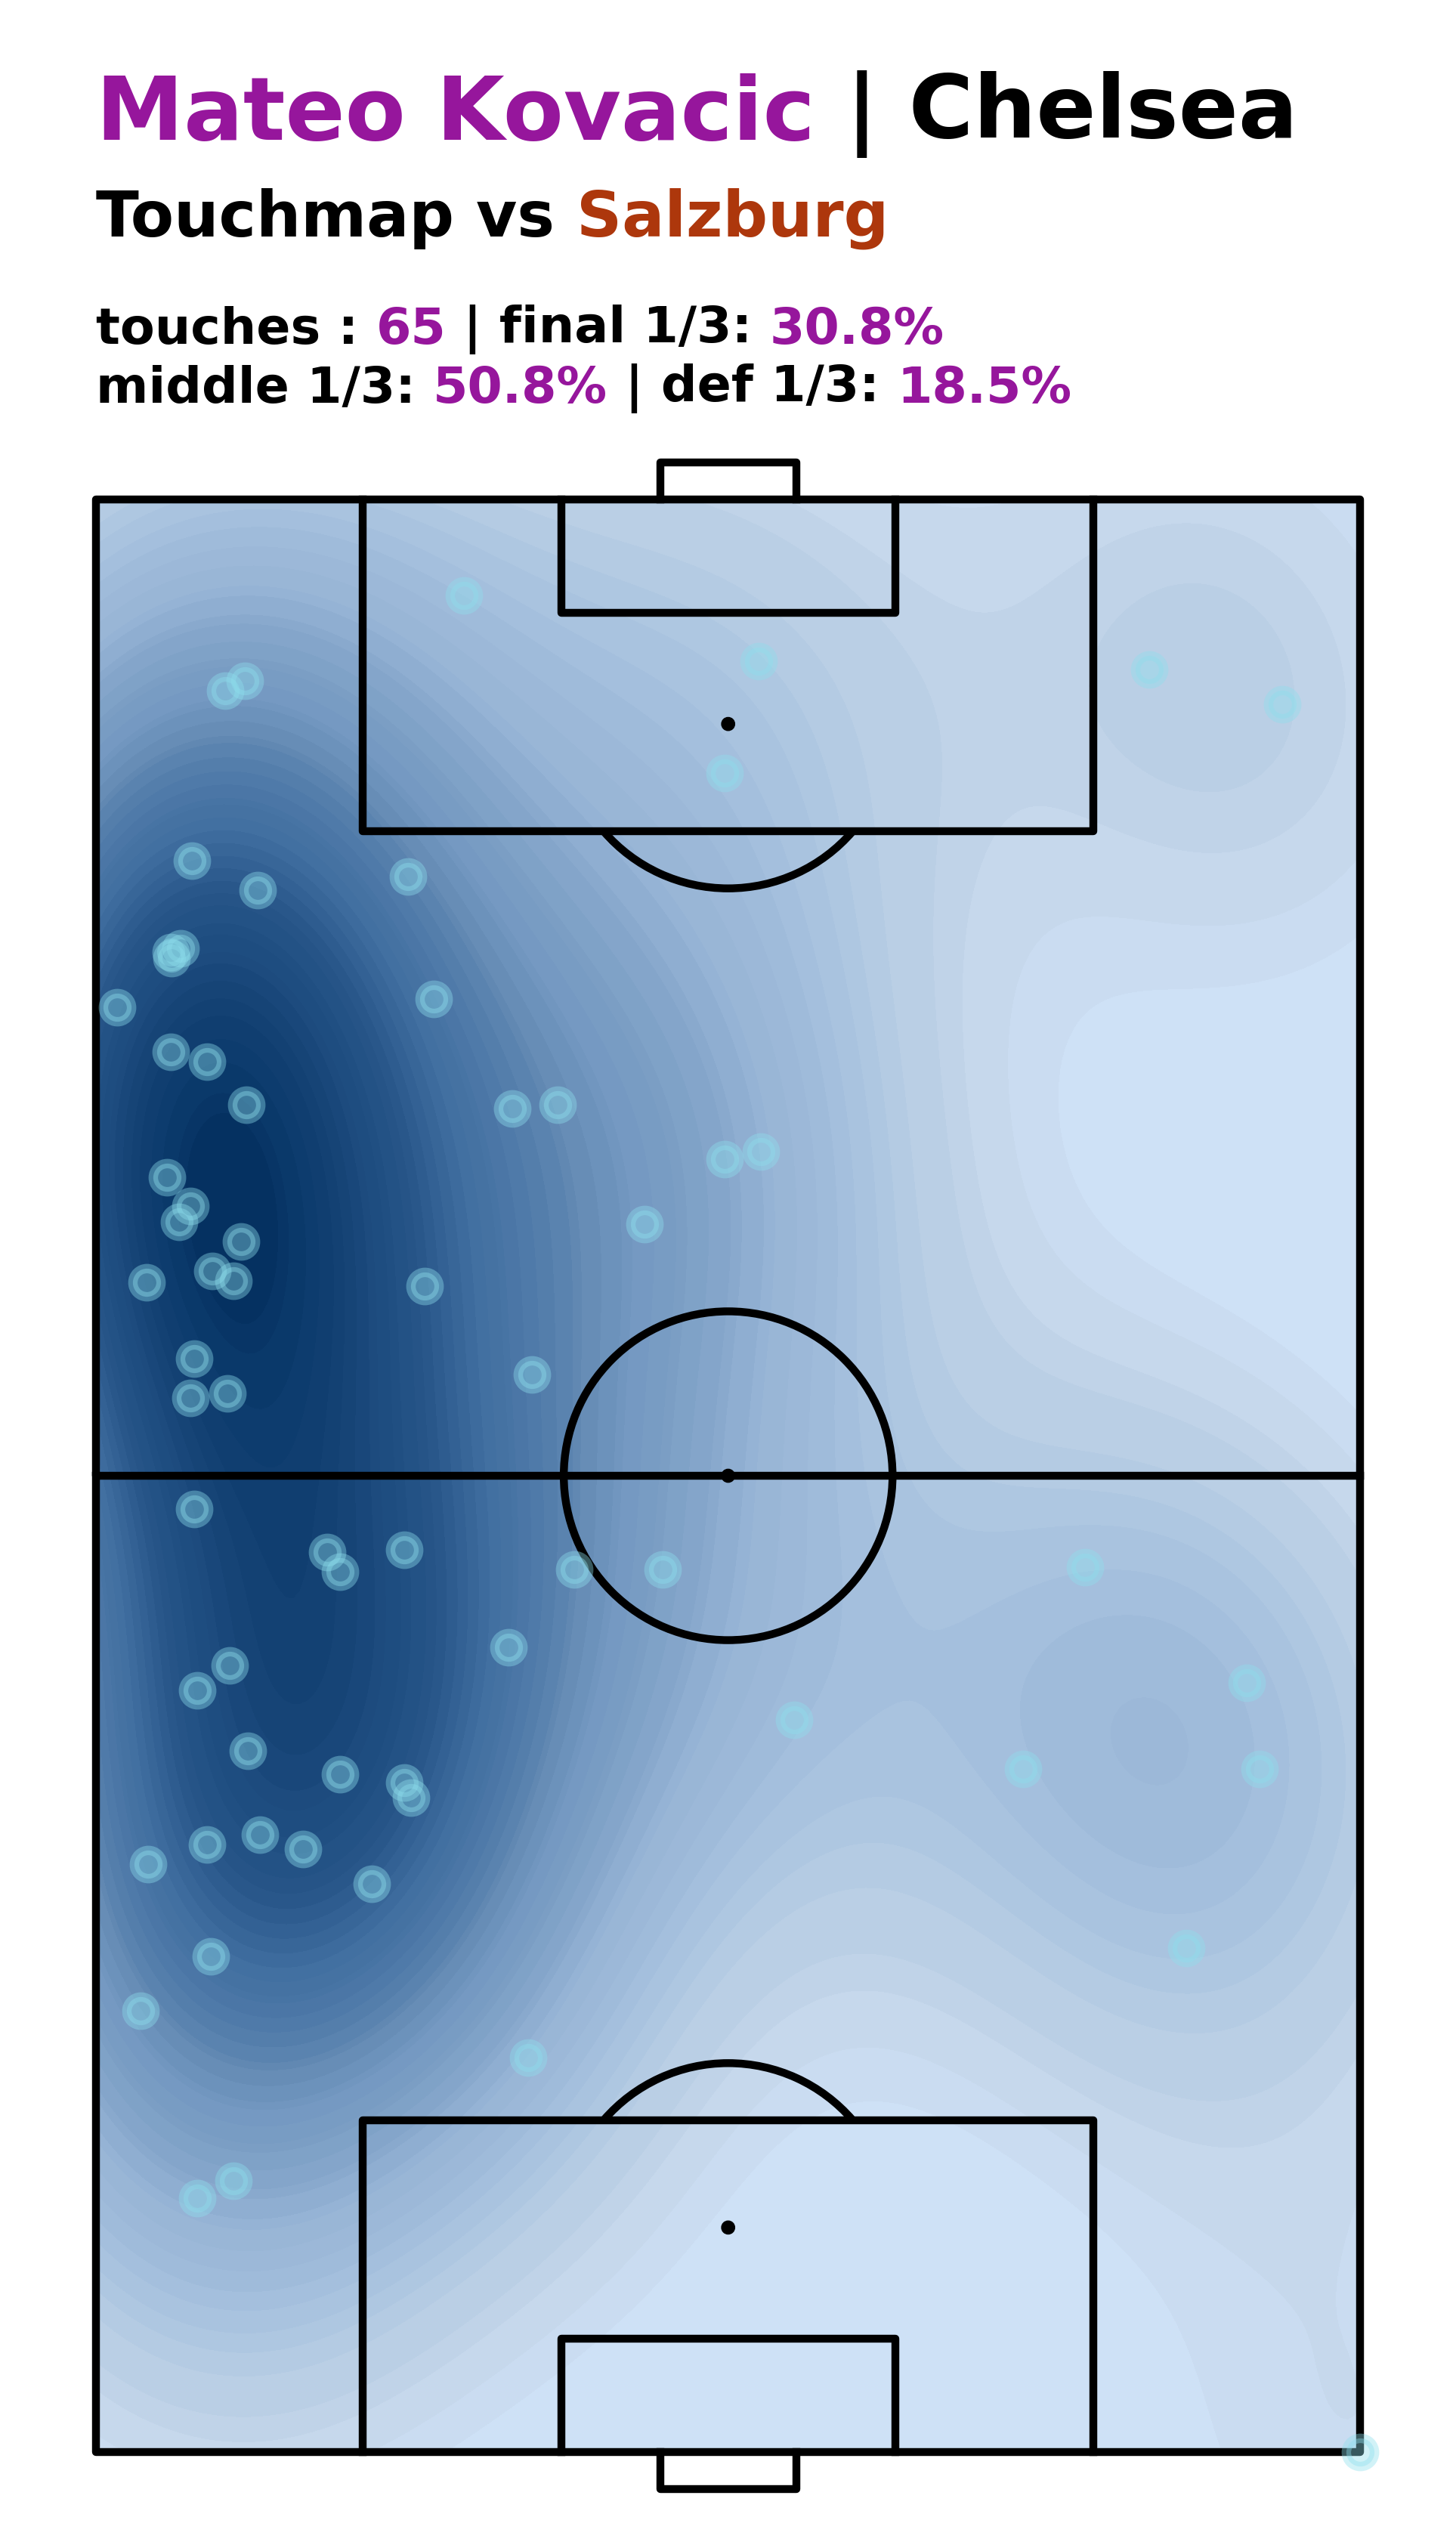

In [10]:
fig = plt.figure(figsize = (6,6), dpi = 600)
ax = plt.subplot(111)
pitch = VerticalPitch(
    pitch_type='opta',
    goal_type='box',
    linewidth=1.25,
    line_color='black',
)
pitch.draw(ax = ax)

# ax.hlines(y=100, xmax=100, xmin=80)

pitch.kdeplot(
    player_passes.x, player_passes.y , 
    ax=ax, shade=True, 
    levels=100, shade_lowest=True,
    cut=4, zorder=-1, cmap='SOC')


first_half_touches = player_passes[player_passes['period.displayName'] =='FirstHalf']
second_half_touches = player_passes[player_passes['period.displayName'] =='SecondHalf']

##TOUCHES BY HALF
# ax.scatter(first_half_touches.y, first_half_touches.x, s=20, alpha=0.4, lw=1.5, color='#8edfed')
# ax.scatter(second_half_touches.y, second_half_touches.x, s=20, alpha=0.4, lw=1.5, color='#02fa72')

##TOUCHES BY MATCH
ax.scatter(player_passes.y, player_passes.x, s=20, alpha=0.4, lw=1.5, color='#8edfed')

total_touches = player_passes.shape[0]
touches_attacking = len(player_passes[player_passes['x'] >= (100*2)/3])*100/total_touches
touches_middle = len(player_passes[player_passes['x'] >= (100*1)/3])*100/total_touches - touches_attacking
touches_defensive = len(player_passes[player_passes['x'] <= (100*1)/3])*100/total_touches

ax_text(
        x=100, y=122,
        s=f"<{PLAYER_NAME}> | {playing_team}",
        highlight_textprops=[{'size':14, 'weight':'bold', 'color': '#96169c'}],
        ax=ax,
        weight='bold',
        size=14,
        font='DM Sans',
        ha='left'
    )

ax_text(
        x=100, y=116,
        s=f"Touchmap vs <{opp}>",
        highlight_textprops=[{'size':10, 'weight':'bold', 'color': '#ad370c'}],
        ax=ax,
        weight='bold',
        size=10,
        color='black',
        font='DM Sans',
        ha='left'
    )

ax_text(
        x=100, y=110,
        s=f"touches : <{total_touches:.0f}> | final 1/3: <{touches_attacking:.1f}%>",
        highlight_textprops=[{'size':8, 'weight':'bold', 'color': '#96169c'}, {'size':8, 'weight':'bold', 'color': '#96169c'}],
        ax=ax,
        weight='bold',
        size=8,
        font='DM Sans',
        ha='left'
    )

ax_text(
        x=100, y=107,
        s=f"middle 1/3: <{touches_middle:.1f}%> | def 1/3: <{touches_defensive:.1f}%>",
        highlight_textprops=[{'size':8, 'weight':'bold', 'color': '#96169c'}, {'size':8, 'weight':'bold', 'color': '#96169c'}],
        ax=ax,
        weight='bold',
        size=8,
        font='DM Sans',
        ha='left'
    )

# legend_elements = [Line2D([0], [0], marker='o', color='w', label='Scatter',
#                           markerfacecolor='g', markersize=15),
#                    Line2D([0], [0], marker='o', color='w', label='Scatter',
#                           markerfacecolor='b', markersize=15)]
# ax.legend(handles=legend_elements, ["1 Half", "Second Half"])
# ax.legend(legend_elements, ['1st half', '2nd half'])

# ax.annotate(
#     xy=(103, 5),
#     text='Attacking direction',
#     rotation=90,
#     size=7
# )

# ax.annotate(
#     xy=(104,2),
#     xytext=(104,45),
#     text='',
#     arrowprops=dict(arrowstyle='<-',linewidth=0.55)
# )

plt.show()

# plt.savefig(
#     "viz/%s - %s.png"%(PLAYER_NAME, d['matchId']),
#     dpi = 600,
#     facecolor = "none",
#     bbox_inches="tight",
#     edgecolor="none",
#     transparent = False
# )

fig.savefig("viz/Touchmap %s - %s.png"%(PLAYER_NAME, d['matchId']), dpi=600, bbox_inches='tight', pad_inches=0.5)


In [1241]:
TEAM_ID = 15

team_players = passing_data[passing_data['teamId'] == TEAM_ID]

PLAYERS = ['Mateo Kovacic', 'Kai Havertz', 'Jorginho', 'Marc Cucurella', 'Mason Mount', 'Raheem Sterling']

In [1250]:
def plot_kdetouches(ax, fig, playername, df):
    '''
    Plot kde touches for a specific player.
    '''
    data = df.copy()
#     data_player = data[data['player_name'] == playername].reset_index(drop=True)
    data_player = data[data.apply(lambda x: SequenceMatcher(None, x['player_name'], playername).ratio()>0.5,axis=1)]
    total_touches = data_player.shape[0]
    touches_attacking = len(data_player[data_player['x'] >= (100*2)/3])*100/total_touches
    touches_middle = len(data_player[data_player['x'] >= (100*1)/3])*100/total_touches - touches_attacking
    touches_defensive = len(data_player[data_player['x'] <= (100*1)/3])*100/total_touches
    pitch = VerticalPitch(
        pitch_type='opta',
        goal_type='box',
        linewidth=1.25,
        line_color='black',
    )
    pitch.draw(ax=ax)

    pitch.kdeplot(
        data_player.x, data_player.y, 
        ax=ax, shade=True, 
        levels=100, shade_lowest=True,
        cut=20, zorder=-1, cmap='SOC')

    ax.scatter(data_player.y, data_player.x, s=10, alpha=0.4, lw=1.5, color='#8edfed')
    # -- Transformation functions
    ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1])
    ax.set_xlim(ax.get_xlim()[0], ax.get_xlim()[1])
    DC_to_FC = ax.transData.transform
    FC_to_NFC = fig.transFigure.inverted().transform
    # -- Take data coordinates and transform them to normalized figure coordinates
    DC_to_NFC = lambda x: FC_to_NFC(DC_to_FC(x))
    ax_coords = DC_to_NFC((15,109))
    ax_size = 0.018
#     ax_text(
#         x=95, y=115,
#         s=f'{playername}\n<touches {total_touches:.0f} | final third: {touches_third:.0f%}>',
#         highlight_textprops=[{'size':7, 'weight':'normal'}],
#         ax=ax,
#         weight='bold',
#         size=10,
#         font='DM Sans',
#         ha='left'
#     )
    ax_text(
        x=100, y=122,
        s=f"<{playername}>",
        highlight_textprops=[{'size':10, 'weight':'bold', 'color': '#0002BA'}],
        ax=ax,
        weight='bold',
        size=14,
        font='DM Sans',
        ha='left'
    )

    ax_text(
        x=100, y=112,
        s=f"touches : <{total_touches:.0f}> | final 1/3: <{touches_attacking:.1f}%>",
        highlight_textprops=[{'size':6, 'weight':'bold', 'color': '#0002BA'}, {'size':6, 'weight':'bold', 'color': '#0002BA'}],
        ax=ax,
        weight='bold',
        size=6,
        font='DM Sans',
        ha='left'
    )

    ax_text(
        x=100, y=107,
        s=f"middle 1/3: <{touches_middle:.1f}%> | def 1/3: <{touches_defensive:.1f}%>",
        highlight_textprops=[{'size':6, 'weight':'bold', 'color': '#0002BA'}, {'size':6, 'weight':'bold', 'color': '#0002BA'}],
        ax=ax,
        weight='bold',
        size=6,
        font='DM Sans',
        ha='left'
    )
    return ax

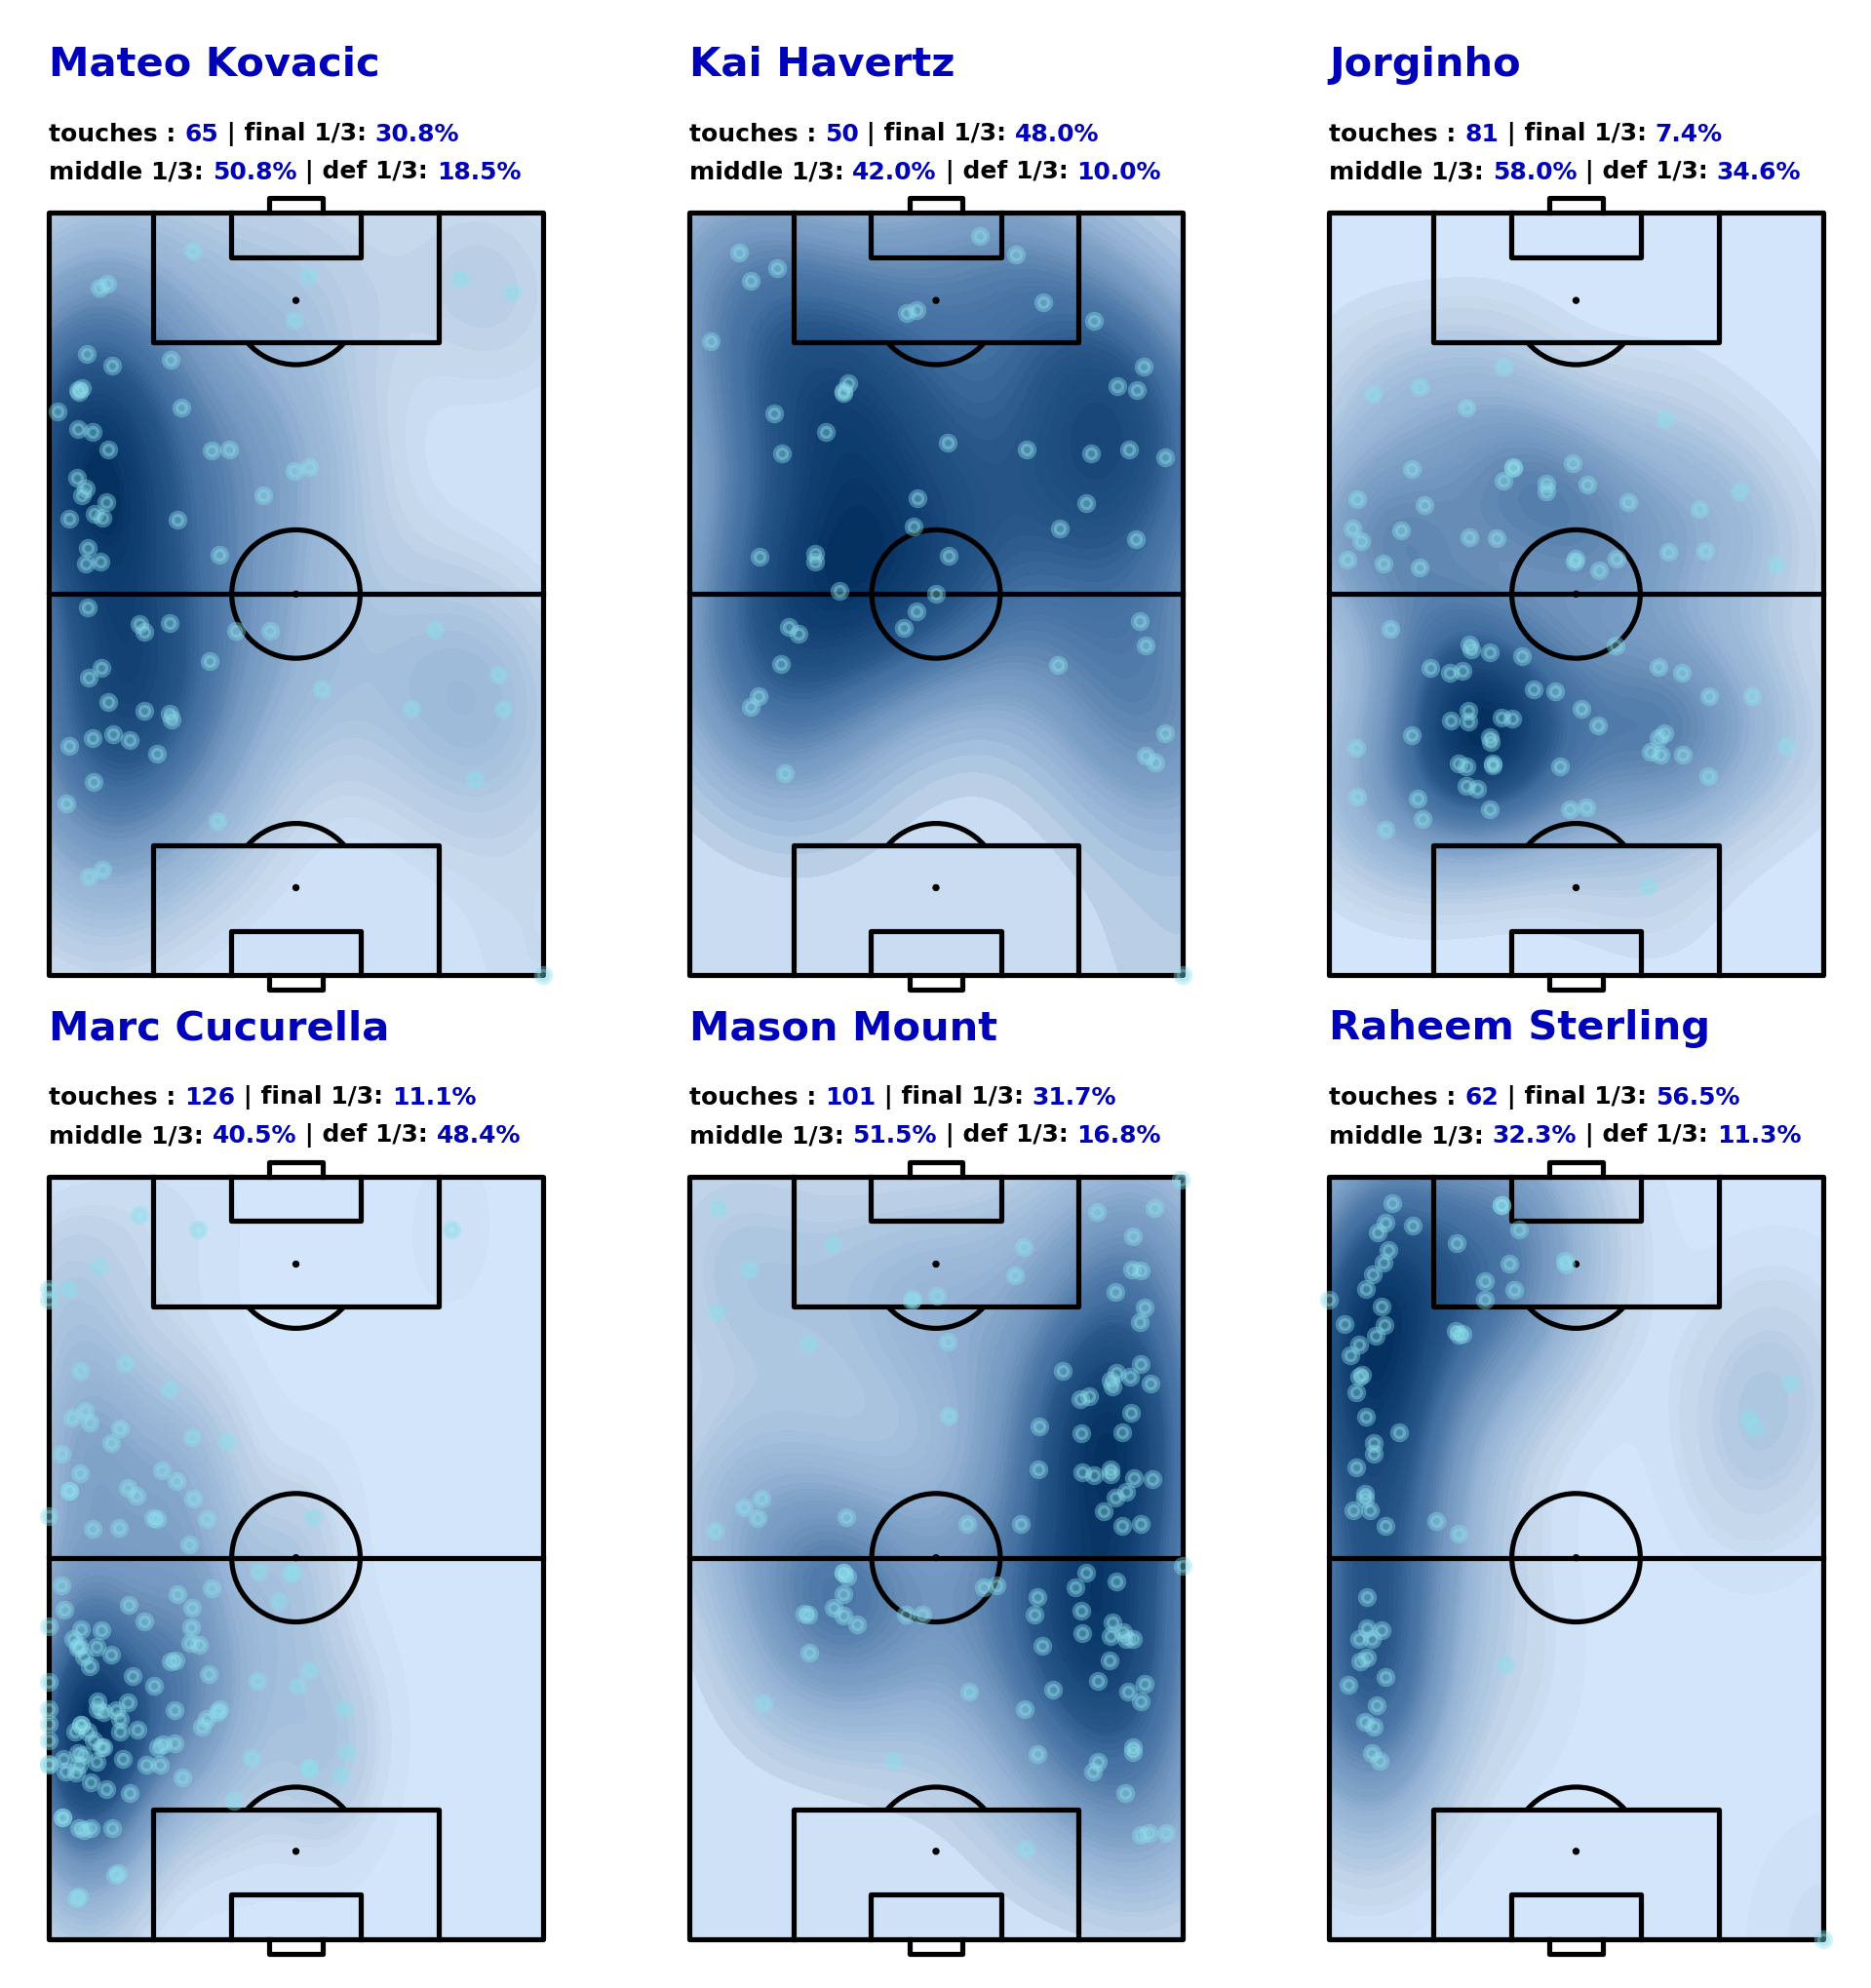

In [1251]:
layout_ = '''
    ABC
    DEF
'''

fig = plt.figure(figsize=(8,8), dpi=300)
axs = fig.subplot_mosaic(
    layout_
)
counter = 0

    
for k, ax in axs.items():
    plot_kdetouches(ax, fig, PLAYERS[counter], team_players)
    counter += 1
    
fig.savefig("viz/Touchmap %s - %s.png"%('Chelsea_', d['matchId']), dpi=600, bbox_inches='tight', pad_inches=0.5,
           facecolor = "#C8DAEE", transparent = True)

